## Modeling and Simulation in Python

Project 1

Manu Patil & Richard Gao

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *
from pandas import read_csv
import numpy
import math
import pprint
from functools import reduce

### What would be the impact on the U.S. population if the flu vaccination was never introduced?

There has been a growing population that believes that the flu vaccine has no effect in preventing the disease. With massive advances in sciences over the years, there is most likely a non-negligble effect of the vaccine. 

To further dive into this question, we will attempt to model the U.S. population with and without the influenza vaccine. In order to model this hypothetical situation we will look at the following parameters:

* number of people vaccinated over time
* birth rate
* death rate
    * due to influenza
    * excluding influenza
* rate of disease spread
* total population

TODO:
Include 3 state model

### Basic Model Breakdown

Time unit = months
System(population, infected, number of people vaccinated, birth rate, death rate<sans influenza>, infection rate, disease death rate<flu effectiveness>)

State( pop, infected people, vaccinated people)
Vaccinated people = read in percentage data and apply to population


Pop = pop *birthrate –pop *death rate <sans influenza>

Without Vaccine Situation
	Infected [t+1] = infected[t] + infected * infection rate
	Killed by flu = Infected* Disease Death rate

With Vaccine situation
	Vaccinated = read in data
Infected [t+1] = infected[t] + infected * infection rate
Killed by Flu = Infected * (population – vaccinated people) * Disease Death rate.










### Read data in from csv

Using the read_csv function from pandas to parse and read in influenza data from the Center for Disease Control and Prevention database.

In [2]:
def fill_list(x, y):
    interval = list(range(x, y))
    return interval

In [3]:
csv = read_csv("data/2016-2017.csv", encoding = "ISO-8859-1")

# Get the index of where each age group starts
new_group_start = []

size_of_csv = None

for size_of_csv, age_group in enumerate(csv.values[0]):
    if not isinstance(age_group, float):
        new_group_start.append(size_of_csv)  

# Isolate and retrieve just the U.S population row
us_pop_row = 54
skiprows = list(filter(lambda x : x != 2 and x != us_pop_row, range(0, us_pop_row + 1)))

# Go through each age group and get SAMPLE and puth each age groups months into a month array
rates_by_month = [[], [], [], [], [], [], [], [], [], [], []] # 2D array containing arrays of rates by different months
sample_sizes = [] # 1D array, each index corresponds to an array in rates_by_month
months = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May',]

# Loop through each age group    
for index in range(0, len(new_group_start)):
    if index + 1 == len(new_group_start): # Last age group
        interval = fill_list(new_group_start[index], size_of_csv)
    else: 
        interval = fill_list(new_group_start[index], new_group_start[index + 1])

    # Get data for an age group
    df = read_csv('data/2016-2017.csv', skipinitialspace=True, skiprows=skiprows, usecols=interval, nrows=1, encoding="ISO-8859-1")

    # Put sample size for each age group into sample_sizes
    sample_sizes.append(df[df.columns[4]].iloc[0])

    # Put each month's rate into rates_by_month
    for month_num, month in enumerate(months):
        month_name = f'{month}.{index}'
        if index == 0:
            month_name = month
        if not isinstance(df[[month_name]].iloc[0][month_name], float):
            rates_by_month[month_num].append(0)
        else:
            rates_by_month[month_num].append(df[[month_name]].iloc[0][month_name])

# Compute total sample population in us
sample_total = reduce((lambda x, y: x + y), sample_sizes)

# Calculate influeza rates by month in us
us_influeza_vac_by_month = []
for month in rates_by_month:
    sum = 0
    for index, rate in enumerate(month):
        sum += sample_sizes[index] * rate
    us_influeza_vac_by_month.append(sum / sample_total)

Here we are reporting the U.S. vaccination rates per month.

In [4]:
# Print us population vaccination by month without compounding 
vacc = []
vacc.insert(0, us_influeza_vac_by_month[0])
vacc_prev = vacc[0];
for i in range(1,10,1):
    vacc.insert(i, us_influeza_vac_by_month[i] - vacc_prev)
    vacc_prev = us_influeza_vac_by_month[i] 
vacc;

In [5]:
birth_pop = read_csv('data/BirthRates201718.csv', skipinitialspace=True, usecols=[2]);

In [6]:
death_pop = read_csv("data/DeathRates2017-18.csv", skipinitialspace=True, usecols=[2]);

### Model

The following function sets up the initial parameters for running simulations.

In [17]:
def Initialize_Simulation(
    initPopulation,
    vaccinationPercent,
    infectionRate,
    vaccineEffectiveRate,
    infectDeathRate,
    diseaseRecoveryRate):
    return System(initpopulation=initPopulation,
                  vaccinationPercent=vaccinationPercent,
                  infection_rate=infectionRate,
                  vaccineEffectiveRate=vaccineEffectiveRate,
                  infectionDeathRate=infectDeathRate,
                  diseaseRecoveryRate=diseaseRecoveryRate)

The next three cells are iterative tests that show the devlopment of the model. The first one simply shows the changes in population by month. The second and third one seperate out the vaccinated and infected populations.

In [ ]:
def Initialize_Simulation_Test(
    initPopulation,
    vaccinationPercent,
    infectionRate,
    vaccineEffectiveRate,
    infectDeathRate,
    diseaseRecoveryRate):
    pops = State(population = TimeSeries(), vaccinated = TimeSeries(), infected = TimeSeries())
    system = System(initpopulation=initPopulation, vaccinationPercent=vaccinationPercent, infection_rate=infectionRate, vaccineEffectiveRate=vaccineEffectiveRate, infectionDeathRate=infectDeathRate, diseaseRecoveryRate=diseaseRecoveryRate)
    return pops, system


In [ ]:
def Population_test():
    
    pops, system = Initialize_Simulation_Test(300000000, vacc, .1,1,1.6/100000, .2) #initPopulation, vaccinationPercent, #infectionRate, vaccineEffectiveRate, infectDeathRate, #diseaseRecoveryRate

    pops.population[0] = system.initpopulation
    months = [1,2,3,4,5,6,7,8,9,10]
    for i in months:       
        pops.population[i] = pops.population[i-1] + birth_pop[birth_pop.columns[0]].iloc[i] - death_pop[death_pop.columns[0]].iloc[i]
    plot(pops.population,':', label = 'Population')
Population_test()

#Change months to range(1,11)
#Change i to months

In [ ]:
def Vaccine_population_Test():
    pops, system = Initialize_Simulation_Test(300000000, vacc, .1,1,1.6/100000, .2) #initPopulation, vaccinationPercent, #infectionRate, vaccineEffectiveRate, infectDeathRate, #diseaseRecoveryRate

    pops.population[0] = system.initpopulation
    pops.vaccinated[0] = 0
    months = [1,2,3,4,5,6,7,8,9,10]
    for i in months:
        deltavaccinated = pops.population[i-1] * system.vaccinationPercent[i-1]/100 
       
        pops.vaccinated[i] = pops.vaccinated[i-1] + deltavaccinated


        pops.population[i] = pops.population[i-1] + birth_pop[birth_pop.columns[0]].iloc[i] - death_pop[death_pop.columns[0]].iloc[i] - deltavaccinated

    plot(pops.population,':', label = 'Population');
    plot(pops.vaccinated, label ='Vaccinated');
Vaccine_population_Test()

This function considers the actual flu in its calculations. 

In [ ]:
def Infection_population_vaccine_Test():
    pops, system = Initialize_Simulation_Test(300000000, vacc, .1,1,1.6/100000, .2) #initPopulation, vaccinationPercent, #infectionRate, vaccineEffectiveRate, infectDeathRate, #diseaseRecoveryRate
    
    pops.population[0] = system.initpopulation
    pops.vaccinated[0] = 0;
    pops.infected[0] = 0;
    months = [1,2,3,4,5,6,7,8,9,10]
    for i in months:
        deltavaccinated = pops.population[i-1] * system.vaccinationPercent[i-1]/100 
        pops.vaccinated[i] = pops.vaccinated[i-1] + deltavaccinated

        deltainfected = pops.population[i-1] * system.infection_rate - pops.infected[i-1] * system.infectionDeathRate - pops.infected[i-1] * system.diseaseRecoveryRate
        pops.infected[i] = pops.infected[i-1] + deltainfected 


        pops.population[i] = pops.population[i-1] + birth_pop[birth_pop.columns[0]].iloc[i] - death_pop[death_pop.columns[0]].iloc[i] - deltavaccinated

    plot(pops.population,':', label = 'Population');
    plot(pops.vaccinated, label ='Vaccinated');
    plot(pops.infected, "--g", label = 'Infected');
    
Infection_population_vaccine_Test();

In [ ]:
def sim_perfect_vaccine(system,vaccinated, infected, population):
    for month in range(1, 11):
        deltavaccinated = population[month-1] * system.vaccinationPercent[month-1] / 100 \
        + infected[month-1] * system.diseaseRecoveryRate
        deltainfected = population[month-1] * system.infection_rate - infected[month-1] * \
        system.infectionDeathRate - infected[month-1] * system.diseaseRecoveryRate
      
        vaccinated[month] = vaccinated[month-1] + deltavaccinated
        infected[month] = infected[month-1] + deltainfected 

        population[month] = population[month-1] + birth_pop[birth_pop.columns[0]].iloc[month] \
        - death_pop[death_pop.columns[0]].iloc[month] - deltavaccinated - deltainfected

    return vaccinated, infected, population

In [ ]:
def sim_imperfect_vaccine(system,vaccinated, infected, population):
    for month in range(1, 11):
        deltavaccinated = population[month-1] * system.vaccinationPercent[month-1] / 100 \
        + infected[month-1] * system.diseaseRecoveryRate
        deltainfected = population[month-1] * system.infection_rate - infected[month-1] * \
        system.infectionDeathRate - infected[month-1] * system.diseaseRecoveryRate
         
        vaccinated[month] = vaccinated[month-1] + deltavaccinated
        infected[month] = infected[month-1] + deltainfected 
        population[month] = population[month-1] + birth_pop[birth_pop.columns[0]].iloc[month] - \
        death_pop[death_pop.columns[0]].iloc[month] - deltavaccinated - deltainfected

    return vaccinated, infected, population

In [ ]:
def sim_without_vaccine(system,vaccinated, infected, population):
    for month in range(1, 11):
        vaccinated[month] = 0;

        deltainfected = population[month-1] * system.infection_rate - infected[month-1] \
        * system.infectionDeathRate - infected[month-1] * system.diseaseRecoveryRate
        infected[month] = infected[month-1] + deltainfected 


        population[month] = population[month-1] + birth_pop[birth_pop.columns[0]].iloc[month] \
        - death_pop[death_pop.columns[0]].iloc[month] - deltainfected #-deltavaccinated

    return vaccinated, infected, population

In [ ]:
def run_Simulation(system, vaccine_function):
    vaccinated = TimeSeries();
    infected = TimeSeries();
    population = TimeSeries();
    population[0] = system.initpopulation
    vaccinated[0] = 0;
    infected[0] = 0;
    
    vaccinated, infected, population = vaccine_function(system,vaccinated, infected, population);
    
    return population, vaccinated, infected

In [ ]:
def plot_results(population, vaccinated, infected):
    plot(population,':', label = 'Population');
    plot(vaccinated, label ='Vaccinated');
    plot(infected, "--g", label = 'Infected');
    

### Simulation

With Vaccine

In [ ]:
system = Initialize_Simulation(300000000, vacc, .1,1,1.6/100000, .2) #initPopulation, vaccinationPercent, #infectionRate, vaccineEffectiveRate, infectDeathRate, #diseaseRecoveryRate

population, vaccinated, infected = run_Simulation(system, sim_perfect_vaccine)

plot_results(population, vaccinated, infected)

Without Vaccine

In [ ]:
system = Initialize_Simulation(300000000, vacc, .1,1,1.6/100000, .2) #initPopulation, vaccinationPercent, infectionRate, vaccineEffectiveRate, infectDeathRate, diseaseRecoveryRate

population, vaccinated, infected = run_Simulation(system, sim_without_vaccine)

plot_results(population, vaccinated, infected)

### Metrics

Well, we made a cool graph. Swell. But, how does that help us. In order to be able to draw results we need to consider some form of a metric. 
Enter: Death!
We can measure how many people die in the two variations of the model and compare the results to see what sort of effect the vaccine has had.


Let's start by adding a TimeSeries to measure death

In [18]:
def Initialize_Simulation(
    initPopulation,
    vaccinationPercent,
    infectionRate,
    vaccineEffectiveRate,
    infectDeathRate,
    diseaseRecoveryRate):
    return System(initpopulation=initPopulation,
                  vaccinationPercent=vaccinationPercent,
                  infection_rate=infectionRate,
                  vaccineEffectiveRate=vaccineEffectiveRate,
                  infectionDeathRate=infectDeathRate,
                  diseaseRecoveryRate=diseaseRecoveryRate)

In [19]:
def run_Simulation(system, vaccine_function):
    vaccinated = TimeSeries();
    infected = TimeSeries();
    population = TimeSeries();
    death = TimeSeries();
    population[0] = system.initpopulation
    vaccinated[0] = 0;
    infected[0] = 0;
    death[0] = 0;
    
    vaccinated, infected, population, death = vaccine_function(system,vaccinated, infected, population, death);
    
    return population, vaccinated, infected, death;

In [20]:
def sim_imperfect_vaccine(system, vaccinated, infected, population, death):
    for month in range(1, 11):
        populationRatio = population[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])
        vaccinatedRatio = vaccinated[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])
        infectedRatio = infected[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])
        
        deltavaccinated = population[month-1] * system.vaccinationPercent[month-1] / 100 \
        + infected[month-1] * system.diseaseRecoveryRate \
        - death_pop[death_pop.columns[0]].iloc[month] * vaccinatedRatio;
        
        deltainfected = population[month-1] * system.infection_rate - infected[month-1] * system.infectionDeathRate \
        - infected[month-1] * system.diseaseRecoveryRate \
        -death_pop[death_pop.columns[0]].iloc[month] * infectedRatio
         
        vaccinated[month] = vaccinated[month-1] + deltavaccinated
        infected[month] = infected[month-1] + deltainfected 
        population[month] = population[month-1] + birth_pop[birth_pop.columns[0]].iloc[month] - \
        death_pop[death_pop.columns[0]].iloc[month] *populationRatio - deltavaccinated - deltainfected
        
        death[i] = infected[month-1] * system.infectionDeathRate + death_pop[death_pop.columns[0]].iloc[month]

    return vaccinated, infected, population, death

In [21]:
def sim_without_vaccine(system, vaccinated, infected, population, death):
    for month in range(1, 11):
        populationRatio = population[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])
        vaccinatedRatio = vaccinated[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])
        infectedRatio = infected[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])

        deltainfected = population[month-1] * system.infection_rate - infected[month-1] \
        * system.infectionDeathRate - infected[month-1] * system.diseaseRecoveryRate \
        - death_pop[death_pop.columns[0]].iloc[month] * infectedRatio;
        
        deltavaccinated = infected[month-1] * system.diseaseRecoveryRate \
        - death_pop[death_pop.columns[0]].iloc[month] *vaccinatedRatio; 
        
        vaccinated[month] = vaccinated[month-1] + deltavaccinated;
        infected[month] = infected[month-1] + deltainfected; 
        population[month] = population[month-1] + birth_pop[birth_pop.columns[0]].iloc[month] \
        - death_pop[death_pop.columns[0]].iloc[month] * populationRatio - deltainfected -deltavaccinated;
        
        death[i] = infected[month-1] * system.infectionDeathRate + death_pop[death_pop.columns[0]].iloc[month]

    return vaccinated, infected, population, death

In [22]:
def plot_results(population, vaccinated, infected):
    plot(population,':', label = 'Population');
    plot(vaccinated, label ='Vaccinated');
    plot(infected, "--g", label = 'Infected');    

With these changes, We can now run the simulation and plot the deaths over time

In [23]:
def vaccine_Simulation():
    system = Initialize_Simulation(300000000, vacc, .1,1,1.6/100000, .2) #initPopulation, vaccinationPercent, #infectionRate, vaccineEffectiveRate, infectDeathRate, #diseaseRecoveryRate

    population, vaccinated, infected, death= run_Simulation(system, sim_imperfect_vaccine)

    return death;

In [24]:
def nonVaccine_Simulation():
    system = Initialize_Simulation(300000000, vacc, .1,1,1.6/100000, .2) #initPopulation, vaccinationPercent, #infectionRate, vaccineEffectiveRate, infectDeathRate, #diseaseRecoveryRate

    population, vaccinated, infected, death= run_Simulation(system, sim_without_vaccine)
    return death;

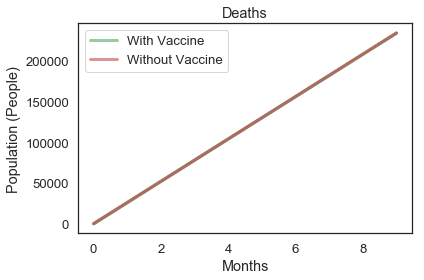

In [25]:
WithVaccineDeath = vaccine_Simulation();
WithoutVaccineDeath = nonVaccine_Simulation();

plot (WithVaccineDeath);
plot (WithoutVaccineDeath);
plot (WithVaccineDeath, label = 'With Vaccine');
plot (WithoutVaccineDeath, label = "Without Vaccine");
decorate(title='Deaths',
             xlabel='Months', 
             ylabel='Population (People)')

The above plot shows the two lines as very nearly overlapping. In order to see a clearer picture, let us remove the general deaths and focus only on the influenza deaths

In [26]:
def sim_without_vaccine(system, vaccinated, infected, population, death):
    for month in range(1, 11):
        populationRatio = population[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])
        vaccinatedRatio = vaccinated[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])
        infectedRatio = infected[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])

        deltainfected = population[month-1] * system.infection_rate - infected[month-1] \
        * system.infectionDeathRate - infected[month-1] * system.diseaseRecoveryRate \
        - death_pop[death_pop.columns[0]].iloc[month] * infectedRatio;
        
        deltavaccinated = infected[month-1] * system.diseaseRecoveryRate \
        - death_pop[death_pop.columns[0]].iloc[month] *vaccinatedRatio; 
        
        vaccinated[month] = vaccinated[month-1] + deltavaccinated;
        infected[month] = infected[month-1] + deltainfected; 
        population[month] = population[month-1] + birth_pop[birth_pop.columns[0]].iloc[month] \
        - death_pop[death_pop.columns[0]].iloc[month] * populationRatio - deltainfected -deltavaccinated;
        
        death[i] = infected[month-1] * system.infectionDeathRate

    return vaccinated, infected, population, death

In [27]:
def sim_imperfect_vaccine(system, vaccinated, infected, population, death):
    for month in range(1, 11):
        populationRatio = population[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])
        vaccinatedRatio = vaccinated[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])
        infectedRatio = infected[month-1]/(population[month-1]+ vaccinated[month-1]+infected[month-1])
        
        deltavaccinated = population[month-1] * system.vaccinationPercent[month-1] / 100 \
        + infected[month-1] * system.diseaseRecoveryRate \
        - death_pop[death_pop.columns[0]].iloc[month] * vaccinatedRatio;
        
        deltainfected = population[month-1] * system.infection_rate - infected[month-1] * system.infectionDeathRate \
        - infected[month-1] * system.diseaseRecoveryRate \
        -death_pop[death_pop.columns[0]].iloc[month] * infectedRatio
         
        vaccinated[month] = vaccinated[month-1] + deltavaccinated
        infected[month] = infected[month-1] + deltainfected 
        population[month] = population[month-1] + birth_pop[birth_pop.columns[0]].iloc[month] - \
        death_pop[death_pop.columns[0]].iloc[month] *populationRatio - deltavaccinated - deltainfected
        
        death[i] = infected[month-1] * system.infectionDeathRate 

    return vaccinated, infected, population, death

Death Count at end of year with Vaccine: 902.5168524731355
Death Count at end of year without Vaccine: 1217.4114020402621


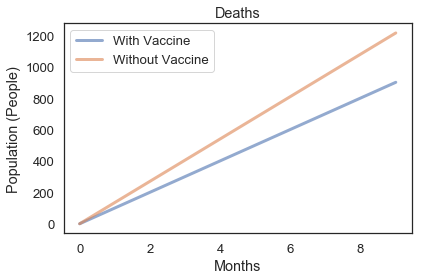

In [28]:
WithVaccineDeath = vaccine_Simulation();
WithoutVaccineDeath = nonVaccine_Simulation();

plot (WithVaccineDeath, label = 'With Vaccine');
plot (WithoutVaccineDeath, label = "Without Vaccine");
decorate(title='Deaths',
             xlabel='Months', 
             ylabel='Population (People)')
print('Death Count at end of year with Vaccine:', WithVaccineDeath[9])
print('Death Count at end of year without Vaccine:', WithoutVaccineDeath[9])

### Results
With this graphic and the Death values displayed above it seems that the effects of the vaccine is indeed a benefitial one... RICHARD HALPPP

### Interpretation